In [5]:
import os, pathlib

import matplotlib.pyplot as plt
from matplotlib import rcParams, rc_context
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

if 'project_dir' not in globals():
  project_dir = pathlib.Path.cwd().parent
os.chdir(project_dir)

rcParams['figure.figsize'] = (20, 4)
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True

# Two datasources
This notebook provides some exploratory analysis of the truck data.
Note that some data has changed since the publication and hence some metrics are slightly changed compared to 2018 and 2019 publication to complex networks.

In [8]:
zip_data = pd.read_pickle('data/1-import/zip-data.pkl')
csv_data = pd.read_pickle('data/1-import/csv-data.pkl')

## Date of measurements

<AxesSubplot:xlabel='datetime'>

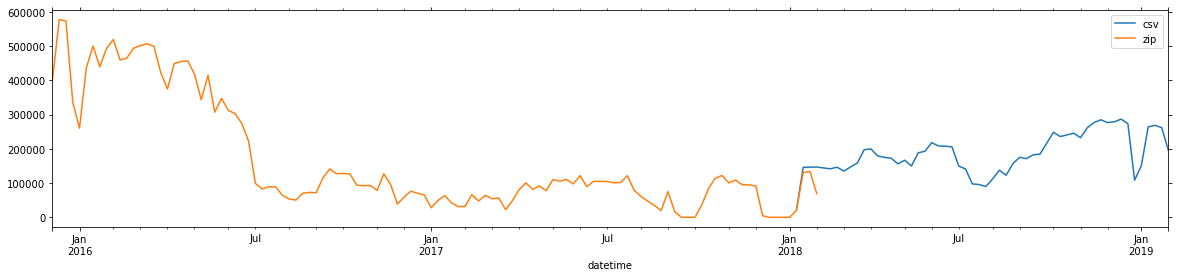

In [9]:
pd.DataFrame(
  {'csv': pd.Series(1, index=csv_data['datetime']).resample('W').count(),
   'zip': pd.Series(1, index=zip_data['datetime']).resample('W').count()
  }).plot()

## Time of measurements

<AxesSubplot:xlabel='Hour of day', ylabel='Relative frequency'>

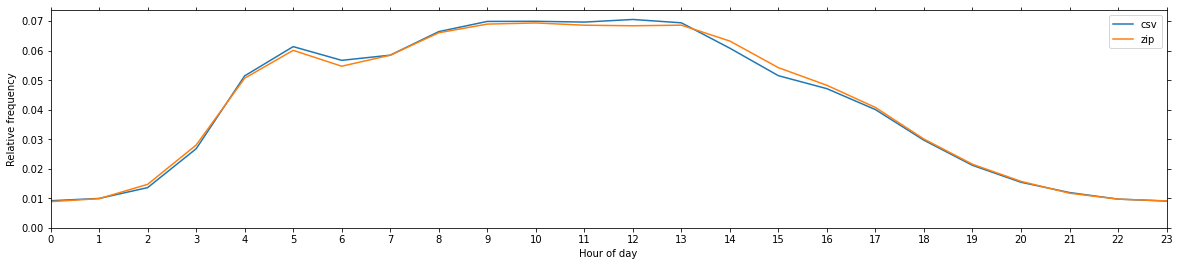

In [10]:
pd.DataFrame({
  'csv': csv_data['datetime'].dt.hour.value_counts(normalize=True, sort=False),
  'zip': zip_data['datetime'].dt.hour.value_counts(normalize=True, sort=False)
}).plot(xticks=range(24), xlabel='Hour of day', ylabel='Relative frequency',
       xlim=(0, 23), ylim=0)

# Merging

In [11]:
csv_data_ = csv_data.loc[:, list(zip_data.columns) + ['velocity', 'lane']]
zip_data_ = zip_data[zip_data['datetime'].dt.year <= 2017].copy()
before_cleaning = (
  pd.concat([csv_data_, zip_data_], ignore_index=True).sort_values('datetime'))
after_dropna = before_cleaning.dropna(subset=['entity'])
after_dropduplicates = (
  after_dropna.drop_duplicates(['entity', 'datetime'], ignore_index=True))
all_data = {'csv': csv_data_, 
            'zip': zip_data_,
            'before cleaning': before_cleaning,
            'after dropna': after_dropna, 
            'after drop_duplicates': after_dropduplicates}

In [12]:
pd.Series({
  'zip data'             : len(zip_data),
  'zip data before 2018' : len(all_data['zip']),
  'csv data'             : len(all_data['csv']),
  'full data'            : len(all_data['before cleaning']),
  'after dropna'         : len(all_data['after dropna']),
  'after drop_duplicates': len(all_data['after drop_duplicates'])
})

zip data                 18678420
zip data before 2018     18324095
csv data                 10371665
full data                28695760
after dropna             24028735
after drop_duplicates    24028734
dtype: int64

  0%|          | 0/5 [00:00<?, ?it/s]

<AxesSubplot:>

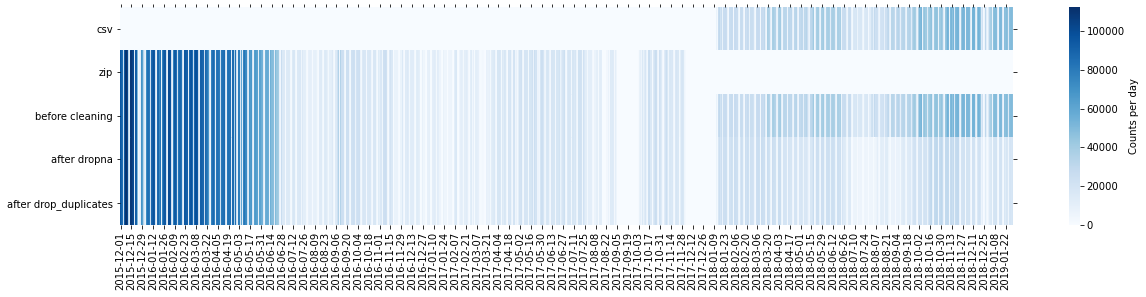

In [13]:
dt_ = pd.DataFrame(
  {name_: (
    pd.Series(np.ones(len(data_)), index=data_['datetime']
             ).resample('D').count().sort_index())
   for name_, data_ in tqdm(all_data.items())}
).fillna(0).sort_index()
dt_.index = dt_.index.date
sns.heatmap(dt_.T, cmap='Blues', cbar_kws={'label': 'Counts per day'})

## Number of measurements per truck

  0%|          | 0/5 [00:00<?, ?it/s]

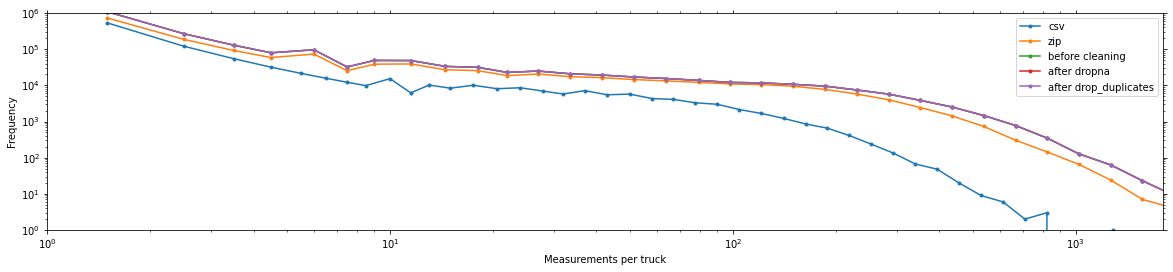

In [50]:
t_ = list()
for label, data_ in tqdm(all_data.items()):
  frequency_list = data_['entity'].value_counts().values
  bins = np.logspace(start=np.log10(1), stop=np.log10(max(frequency_list)))
  counts, bins = np.histogram(frequency_list, bins=np.unique(np.round(bins)))
  for x, y in zip(bins[:-1] + np.diff(bins)/2, counts):
    t_.append(dict(x=x, y=y, label=label))
  pd.Series(counts, index=bins[:-1] + np.diff(bins)/2).plot(
    marker='.', loglog=True, xlim=1, ylim=1, xlabel='Measurements per truck', 
    ylabel='Frequency', label=label)
plt.legend()

## Distribution of seconds between two successive measurements at same location

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 26.6 s, sys: 2.7 s, total: 29.3 s
Wall time: 29.4 s


<AxesSubplot:xlabel='Seconds', ylabel='Cumulative probability'>

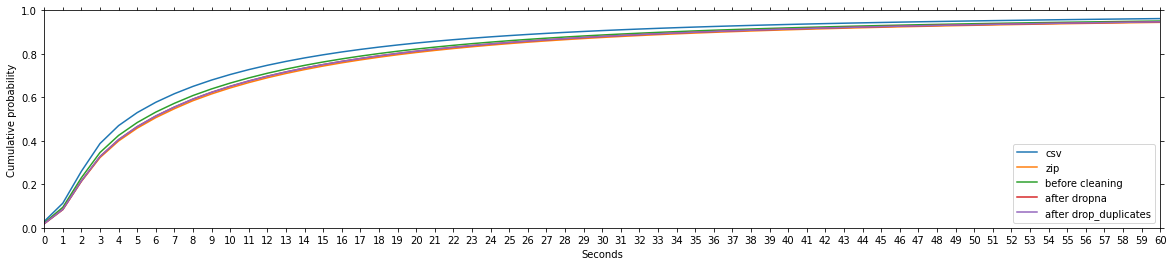

In [192]:
%%time
pd.DataFrame(
  {label: (
    pd.concat(
      [(i['datetime'].astype('int') // 1e9).diff() 
       for _, i in d_.groupby('location', sort=False)]
    ).dropna().value_counts(normalize=True))
  for label, d_ in tqdm(all_data.items())}
).fillna(0).cumsum().sort_index().loc[:60].plot(
  xlim=(0,60), ylim=(0,1), xlabel='Seconds', ylabel='Cumulative probability',
  xticks=range(61))

## Distribution of hours between two successive measurements for the same truck at the same location

CPU times: user 33.9 s, sys: 7.28 s, total: 41.2 s
Wall time: 13min 14s


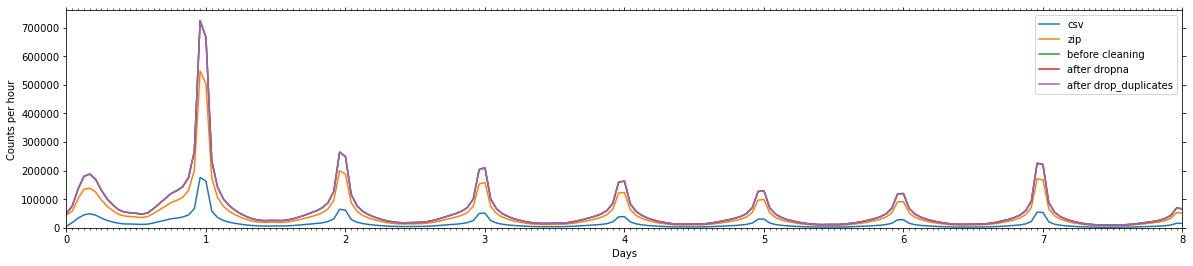

In [199]:
%%time
def groupby(df):
  return (
    df.astype(dict(datetime=int)).groupby(['location', 'entity'])['datetime']
    .diff().dropna() // 3600e9
  ).value_counts(sort=False).sort_index()

result_list = joblib.Parallel(n_jobs=len(all_data))(
  joblib.delayed(groupby)(df) for df in all_data.values())

result_dict = {label: result 
               for label, result in zip(all_data.keys(), result_list)}

for label, result in result_dict.items():
  df = pd.Series(result, name=label)
  df.index = df.index / 24
  df.plot(xlim=(0,8), xlabel='Days', ylabel='Counts per hour')
plt.ylim(0)
plt.legend()
plt.gca().xaxis.set_minor_locator(MultipleLocator(1/24))

## Number of measurements per location over time

CPU times: user 6.2 s, sys: 13.8 s, total: 20 s
Wall time: 3.76 s


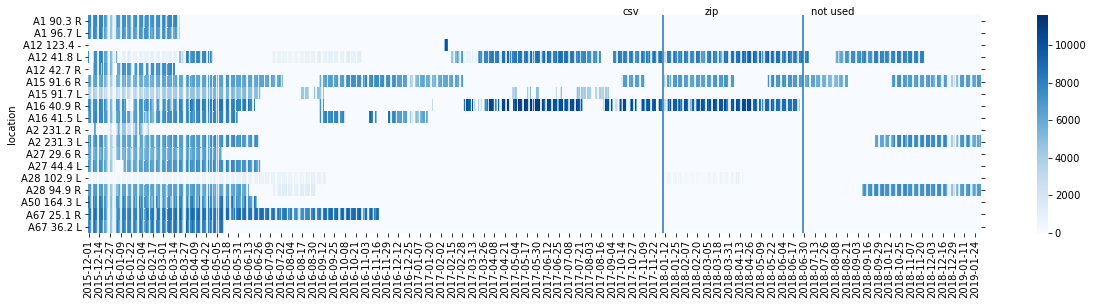

In [202]:
%%time
with rc_context({'xtick.top': False}):
  t_ = (
    all_data['after drop_duplicates'].resample('D', on='datetime')['location']
    .value_counts().unstack().fillna(0).sort_index())
  t_.index = t_.index.date
  ax = sns.heatmap(t_.T, cmap='Blues')
  ax.vlines(700, *ax.get_ylim())
  ax.text(650, 0, 'csv')
  ax.text(750, 0, 'zip')
  ax.vlines(870, *ax.get_ylim())
  ax.text(880, 0, 'not used')

# Truck data after cleaning

In the CN2019 paper, a value of `min_measured=2` would in hindsight have made more sense.

In [203]:
%%time
def report(data):
  return {
    "First measurement": data["datetime"].min(),
    "Last measurement": data['datetime'].max(),
    "Number of unique locations": data["location"].nunique(),
    "Number of measurements": len(data),
    "Number of trucks": data["entity"].nunique()
  }  

data = {'before': all_data['after drop_duplicates'], 
        'after': pd.read_pickle('data/3-process/data.pkl')}

pd.DataFrame({label_: report(data_) for label_, data_ in data.items()})

CPU times: user 48 s, sys: 2.81 s, total: 50.8 s
Wall time: 50.8 s


,before,after
First measurement,2015-12-01 00:00:02,2015-12-01 00:00:02
Last measurement,2019-01-31 23:59:22.510000,2018-06-30 23:58:46.950000
Number of unique locations,18,6
Number of measurements,24028734,11627808
Number of trucks,2050184,1123708


## Number of measurements over time

CPU times: user 2.89 s, sys: 146 ms, total: 3.04 s
Wall time: 3.04 s


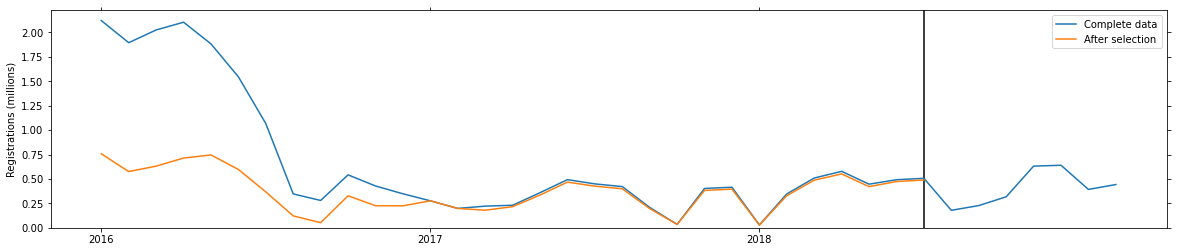

In [204]:
%%time
def convert(x):
  """Groupby month and divide by a million."""
  return ((x.dt.year + x.dt.month / 12).value_counts() / 1e6).sort_index()

ax = pd.DataFrame({
  'Complete data': convert(data['before']['datetime']),
  'After selection': convert(data['after']['datetime'])
}).plot(xticks=[2016, 2017, 2018], ylabel='Registrations (millions)', ylim=0)
ax.vlines(2018.5, *ax.get_ylim(), colors='black')

## Number of measurements per truck

CPU times: user 8.18 s, sys: 154 ms, total: 8.33 s
Wall time: 8.29 s


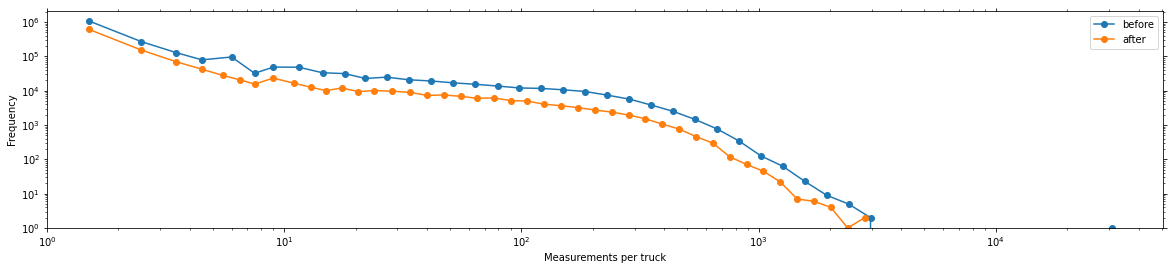

In [205]:
%%time
for label, data_ in data.items():
  frequency_list = data_['entity'].value_counts().values
  bins = np.logspace(start=np.log10(1), stop=np.log10(max(frequency_list)))
  counts, bins = np.histogram(frequency_list, bins=np.unique(np.round(bins)))
  pd.Series(counts, index=bins[:-1] + np.diff(bins)/2, name=label).plot(
    marker='o', loglog=True, xlim=1, ylim=1, xlabel='Measurements per truck', 
    ylabel='Frequency')

plt.legend()

## Distribution of seconds between two successive measurements at same location

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 6.97 s, sys: 731 ms, total: 7.71 s
Wall time: 7.71 s


<AxesSubplot:xlabel='Seconds', ylabel='Cumulative probability'>

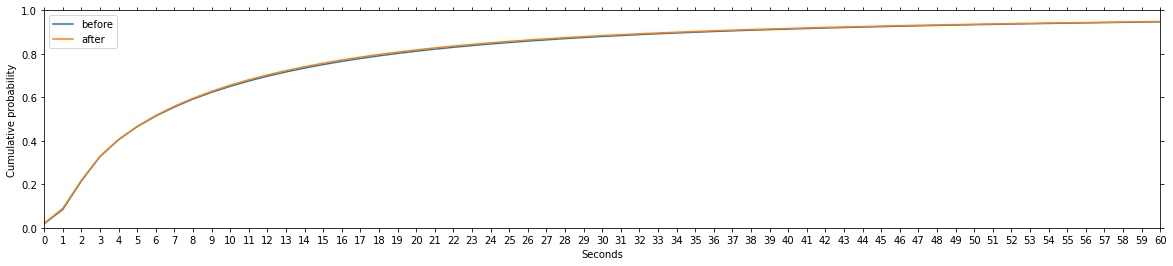

In [206]:
%%time
pd.DataFrame(
  {label: (
    pd.concat(
      [(i['datetime'].astype('int') // 1e9).diff() 
       for _, i in d_.groupby('location', sort=False)]
    ).dropna().value_counts(normalize=True))
  for label, d_ in tqdm(data.items())}
).fillna(0).cumsum().sort_index().loc[:60].plot(
  xlim=(0,60), ylim=(0,1), xlabel='Seconds', ylabel='Cumulative probability',
  xticks=range(61))

## Distribution of hours between two successive measurements for the same truck at the same location

CPU times: user 8.53 s, sys: 2.43 s, total: 11 s
Wall time: 12min 8s


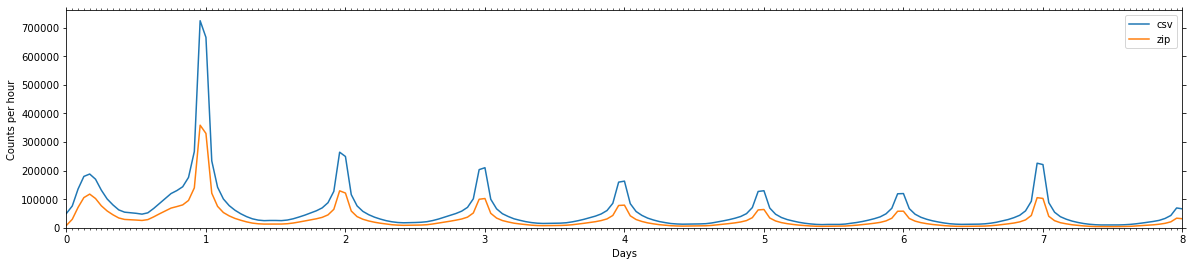

In [210]:
%%time
def groupby(df):
  return (
    df.astype(dict(datetime=int)).groupby(['location', 'entity'])['datetime']
    .diff().dropna() // 3600e9
  ).value_counts(sort=False).sort_index()

result_list = joblib.Parallel(n_jobs=len(data))(
  joblib.delayed(groupby)(df) for df in data.values())

result_dict = {label: result 
               for label, result in zip(all_data.keys(), result_list)}

for label, result in result_dict.items():
  df = pd.Series(result, name=label)
  df.index = df.index / 24
  df.plot(xlim=(0,8), xlabel='Days', ylabel='Counts per hour')
plt.ylim(0)
plt.legend()
plt.gca().xaxis.set_minor_locator(MultipleLocator(1/24))